# Preprocessing of some books by Jane Austen

In [1]:
import numpy as np

In [2]:
import preprocessing as prep

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [21]:
dataset = prep.austen_preprocessing(debug=False)
# dataset is a dictionary
#dataset.keys()

# I saved it just once, since every time the numerical encoding changes
#np.save("dataset", dataset)

['mansfield_park.txt', 'sense_sensibility.txt', 'lady_susan.txt', 'persuasion.txt', 'pride_prejudice.txt', 'northanger_abbey.txt']


Preprocessing Books/mansfield_park.txt 




Preprocessing Books/sense_sensibility.txt 




Preprocessing Books/lady_susan.txt 




Preprocessing Books/persuasion.txt 




Preprocessing (ad hoc) Books/pride_prejudice.txt


Preprocessing Books/northanger_abbey.txt 




In [4]:
dataset = np.load("dataset.npy", allow_pickle=True).item()

word2index = dataset['word2index']
index2word = dataset['index2word']
num_sentences = dataset['num_sentences']
print("word2index size: ", len(word2index))

num_w = word2index['bingley']
retrieved = index2word[num_w]
print("Encoded name: ", num_w)
print("Retrieved name: ", retrieved)

print("Number of sentences in the text: ", len(num_sentences))

word2index size:  12811
Encoded name:  10608
Retrieved name:  bingley
Number of sentences in the text:  21898


In [5]:
class AustenDataset(Dataset):
    
    def __init__(self, filepath, transform=None):
        
        dataset = np.load(filepath, allow_pickle=True).item()
        
        self.word2index = dataset['word2index']
        self.index2word = dataset['index2word']
        self.num_sentences = dataset['num_sentences']
        
        self.transform = transform
        
        sorted_seq = sorted(self.num_sentences, key=lambda x: len(x), reverse=True)
        # save original lengths of each sentence (subtract 1 for slicing in x and y)       
        self.seq_len = [len(s) -1 for s in sorted_seq] 
        
        enc_sentences = [torch.LongTensor(enc_s) for enc_s in sorted_seq]
        
        x = [s[:-1] for s in enc_sentences] # last word of each sentence doesn't have a label
        y = [s[1:] for s in enc_sentences] # first word of each sentence doesn't have an x associated
        
        x_padded = pad_sequence(x, batch_first=True)
        y_padded = pad_sequence(y, batch_first=True)
        
        seq_len = np.array(self.seq_len)
        mask = (seq_len > 0)
        
        x_padded = x_padded[mask]
        y_padded = y_padded[mask]
        seq_len = torch.LongTensor(seq_len[mask])

        self.x_padded = x_padded
        self.y_padded = y_padded
        self.seq_len = seq_len
        self.vocab_len = len(self.word2index)
          
    def __len__(self):
        return len(self.x_padded)
        
    def __getitem__(self, idx):
        # Get text
        x = self.x_padded[idx]
        y = self.y_padded[idx]
        length = self.seq_len[idx]
        return (x, y, length)
        

In [6]:
full_dataset = AustenDataset("dataset.npy")

training_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - training_size
train_size = int(0.9 * training_size)
val_size = training_size - train_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_sampler = SubsetRandomSampler(np.arange(train_size))
val_sampler = SubsetRandomSampler(np.arange(val_size))
test_sampler = SubsetRandomSampler(np.arange(test_size))

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=4, drop_last=True, sampler = train_sampler)
val_loader = DataLoader(val_dataset, batch_size = 128, num_workers=4, drop_last=False, sampler = val_sampler)
test_loader = DataLoader(test_dataset, batch_size = 128, num_workers=4, drop_last=False, sampler = test_sampler)

print("Number of batches in train set: ", len(train_loader))

Number of batches in train set:  553


# Training

In [7]:
class Network(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_units, layers_num, dropout_prob=0, linear_size=512):
        super().__init__()
        # Define recurrent layer
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        
        self.rnn = nn.LSTM(input_size=emb_dim, 
                           hidden_size=hidden_units,
                           num_layers=layers_num,
                           dropout=dropout_prob,
                           batch_first=True)
        
        self.l1 = nn.Linear(hidden_units,linear_size)
        self.out = nn.Linear(linear_size,vocab_size) # leave out the '<PAD>' label 
        
    def forward(self, x, seq_lengths, state=None):

        # Embedding of x
        x = self.embedding(x) 
        
        # packing for efficient processing
        packed_input = pack_padded_sequence(x, seq_lengths, batch_first=True)
        
        # propagate through the LSTM
        packed_output, state = self.rnn(packed_input, state)
        
        # unpack for linear layers processing
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        #print("Unpacked output: ", output.size(), '\n')
        
        # Linear layer
        output = F.leaky_relu(self.l1(output))

        # Linear layer with log_softmax (useful for custom cross-entropy)
        output = F.log_softmax(self.out(output), dim=2)

        return output, state

In [8]:
def masked_cross_ent_loss(y_true, y_pred, pad_token=0, debug=False):
    """
    y_true should be of size (batch_size, seq_len)
    y_pred should be of size (batch_size, seq_len, vocab_size) 
    where vocab_size does not count the token '<PAD>' entry.
    """
    
    y_t_flat = y_true.reshape(-1)
    y_p_flat = y_pred.view(-1, y_pred.size()[-1])
    if debug:
        print("y_t_flat.size() : ", y_t_flat.size())
        print("y_p_flat.size() : ", y_p_flat.size())
        
    mask = (y_t_flat>0).float() # consider only the non-padded words
    
    num_tokens = int(torch.sum(mask).item()) # check if .item() is good, otherwise use .data[0]
    if debug:
        print("Num tokens : ", num_tokens)
        
    # for each word choose the log of the prob predicted for the right label
    y_p_masked = y_p_flat[range(y_p_flat.shape[0]), y_t_flat] * mask 
    
    # compute cross entropy
    cross_ent_loss = - torch.sum(y_p_masked) / num_tokens
    if debug:
        print("Cross-entropy : ", cross_ent_loss)
        
    return cross_ent_loss
    

In [9]:
params = dict(vocab_size=len(word2index), emb_dim=100, hidden_units=128, layers_num=2, dropout_prob=0.2)
net = Network(**params)

In [10]:
optimizer = torch.optim.Adamax(net.parameters(), lr=0.1, weight_decay=1e-4)

In [11]:
import time

def train_one_epoch(net, optimizer, train_loader, val_loader, debug=False, verbose=True):
    
    verbose_print = print if verbose else lambda *args, **kwargs : None
    
    train_loss = 0
    val_loss = 0
        
    n_batches = len(train_loader)
    print_every = n_batches // 10
    start_time = time.time()
    
    net.train()
    for i, data in enumerate(train_loader,0):
        x, y, lengths = data
        sorted_x = torch.LongTensor(sorted(x.numpy(), key=lambda x: np.count_nonzero(x), reverse=True))
        sorted_y = torch.LongTensor(sorted(y.numpy(), key=lambda x: np.count_nonzero(x), reverse=True))
        sorted_lengths = torch.LongTensor(sorted(lengths.numpy(), key=lambda x: x, reverse=True))

        L_max = sorted_lengths.max().item()
        y_trunc = sorted_y[:,:L_max]

        optimizer.zero_grad()
        
        try:
            output, _ = net(sorted_x,sorted_lengths) # returns (output, state)
        except RuntimeError:
            print("Lengths: ", sorted_lengths)
            
        loss = masked_cross_ent_loss(y_trunc, output, pad_token=0, debug=debug)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if ((i+1) % (print_every) == 0) or (i == n_batches - 1):
                verbose_print('\r'+"Batch {}/{}, {:d}% \t Train loss: {:.3f} took: {:.2f}s ".format(
                        i+1, n_batches, int(100 * (i+1) / n_batches), train_loss / (i+1),
                        time.time() - start_time), end=' ')
    
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader,0):

            x, y, lengths = data
            sorted_x = torch.LongTensor(sorted(x.numpy(), key=lambda x: np.count_nonzero(x), reverse=True))
            sorted_y = torch.LongTensor(sorted(y.numpy(), key=lambda x: np.count_nonzero(x), reverse=True))
            sorted_lengths = torch.LongTensor(sorted(lengths.numpy(), key=lambda x: x, reverse=True))

            L_max = sorted_lengths.max().item()
            y_trunc = sorted_y[:,:L_max]

            output, _ = net(sorted_x, sorted_lengths) # returns (output, state)
            loss = masked_cross_ent_loss(y_trunc, output, pad_token=0, debug=debug)

            val_loss += loss.item()

    return net, optimizer, train_loss/len(train_loader), val_loss/len(val_loader)

In [50]:
# first cycle of training
n_epochs = 20
train_log = []
val_log = []
for e in range(n_epochs):    
    
    start_time = time.time()
    net, optimizer, train_loss, val_loss = train_one_epoch(net, optimizer, train_loader, val_loader, debug=False)
    epoch_time = time.time() - start_time
    torch.save(net.state_dict(), 'params'+str(e)+'.pth')
    train_log.append(train_loss)
    val_log.append(val_loss)
    print("\nEpoch: %d - time: %.2f - train loss: %.4f - val loss: %.4f"%((e+1), epoch_time, train_loss, val_loss))
torch.save(net.state_dict(), 'final_params.pth')

Batch 553/553, 100% 	 Train loss: 5.903 took: 2590.44s  
Epoch: 1 - time: 2718.21 - train loss: 5.9026 - val loss: 5.4374
Batch 553/553, 100% 	 Train loss: 5.296 took: 2572.29s  
Epoch: 2 - time: 2703.51 - train loss: 5.2963 - val loss: 5.1771
Batch 553/553, 100% 	 Train loss: 5.140 took: 2611.81s  
Epoch: 3 - time: 2740.92 - train loss: 5.1401 - val loss: 5.0704
Batch 553/553, 100% 	 Train loss: 5.052 took: 2616.86s  
Epoch: 4 - time: 2738.02 - train loss: 5.0517 - val loss: 5.0309
Batch 553/553, 100% 	 Train loss: 5.017 took: 2613.74s  
Epoch: 5 - time: 2741.10 - train loss: 5.0170 - val loss: 5.0114
Batch 553/553, 100% 	 Train loss: 5.001 took: 2599.53s  
Epoch: 6 - time: 2729.39 - train loss: 5.0011 - val loss: 4.9891
Batch 553/553, 100% 	 Train loss: 4.990 took: 2588.18s  
Epoch: 7 - time: 2715.93 - train loss: 4.9905 - val loss: 4.9924
Batch 553/553, 100% 	 Train loss: 4.983 took: 2591.37s  
Epoch: 8 - time: 2726.06 - train loss: 4.9832 - val loss: 4.9748
Batch 553/553, 100% 	 Tr

In [12]:
train_log = list(np.load("train_log.npy"))
val_log = list(np.load("val_log.npy"))

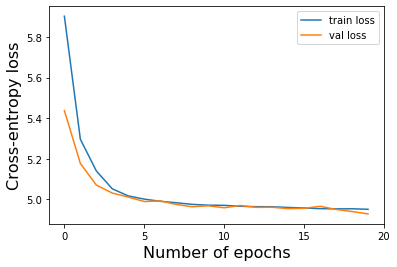

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(train_log), label = 'train loss')
plt.plot(np.array(val_log), label='val loss')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Cross-entropy loss', fontsize=16)
plt.xticks(np.arange(0,5)*5)
plt.legend()
plt.show()

In [59]:
np.save("train_log", train_log)
np.save("val_log", val_log)

## Text generation

In [53]:
trained_net = Network(**params)
trained_net.load_state_dict(torch.load('final_params.pth'))

<All keys matched successfully>

In [54]:
seed = "You are mr. Darcy I suppose"

In [55]:
def generate_sentence_v0(seed, trained_net, word2index, index2word, len_generated_seq = 10, debug=False, T=1):
    
    # preprocess seed
    import re
    special_chars = ['!','?','&','(',')','*','-','_',':',';','"','\'','1','2','3','4','5','6','7','8','9','0']
    for x in special_chars:
        seed = seed.replace(x,' ')
    full_text = seed.lower()
    full_text = full_text.replace('mr.','mr')
    full_text = full_text.replace('mrs.','mrs')
    full_text = re.sub('à', 'a', full_text)
    full_text = re.sub('ê', 'e', full_text)
    full_text = re.sub(r'[.]',' .\n', full_text)
    full_text = full_text.replace(',',' ,')
    full_text = full_text.replace('  ',' ')
    
    num_sentence = prep.numerical_encoder(full_text, word2index)
    if debug:
        for i,num_w in enumerate(num_sentence):
            print(i,num_w)
        
    enc_sentence = torch.LongTensor(num_sentence).view(1,-1)
    context = enc_sentence[:,:-1]
    length_context = torch.LongTensor(np.array([len(num_sentence)-1])).view(1)
    last_word = enc_sentence[:,-1].view(1,1)
    length_last = torch.LongTensor([1]).view(1)
    
    if debug:
        print("enc_sentence : ", enc_sentence.size())
        print("context : ", context.size(), context)
        print("length_context: ", length_context.size(), length_context)
        print("last_word: ", last_word.size(), last_word)
        
    with torch.no_grad():
        net.eval()
        _, hidden_context = net(context, length_context)

        gen_words = []
        for i in range(len_generated_seq):
            last_word_ohe, hidden_context = net(last_word, length_last, state=hidden_context)
            prob_last_word = np.exp(last_word_ohe.numpy().flatten()/T)
            prob_last_word = prob_last_word/ prob_last_word.sum()
            
            if debug:
                print("prob_last_word (shape): ", prob_last_word.shape)
                print("Sum of probabilities: ", prob_last_word.sum())
                print("'<PAD>' probability: ", prob_last_word[0])
            last_word_np = np.random.choice(np.arange(len(prob_last_word)), p=prob_last_word)
            gen_words.append(last_word_np)
            last_word = torch.LongTensor([last_word_np]).view(1,1)
            if debug:
                print("Last word: ", last_word_np)
    
    gen_words = np.array(gen_words).flatten()
    decoded_sentence = prep.numerical_decoder(gen_words, index2word)
    output_string = ' '.join(decoded_sentence)
    print("Seed: ", seed, '\n')
    print("Generated sentence: ", output_string)
    print("\nAll toghether: ", seed, output_string)

In [58]:
generate_sentence_v0(seed, trained_net, word2index, index2word, len_generated_seq=100, debug=False, T=1)

Seed:  You are mr. Darcy I suppose 

Generated sentence:  you feelings it will be said just s there time , time is nothing from arrear . about . of occupies from i were required i am sorry you . to convince none but i do not keep them , however , by my sisters , never kept feel any chance him our way of interest black on this morning as tom carteret to let care at home from her as when the best better they are very congratulated , replied the time , worth concurrence into tambour . , which you know of the china that seizing , likes

All toghether:  You are mr. Darcy I suppose you feelings it will be said just s there time , time is nothing from arrear . about . of occupies from i were required i am sorry you . to convince none but i do not keep them , however , by my sisters , never kept feel any chance him our way of interest black on this morning as tom carteret to let care at home from her as when the best better they are very congratulated , replied the time , worth concurrence int